In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fide-google-efficiency-chess-ai-challenge/Screenshot 2024-10-09 at 10.45.28AM.png


In [3]:
import requests
requests.get('http://www.google.com',timeout=10).ok

True

In [4]:
%%capture
# ensure we are on the latest version of kaggle-environments
!pip install --upgrade kaggle-environments

In [6]:
from kaggle_environments import make
env = make("chess", debug=True)

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3121: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3121: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



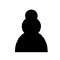
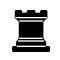
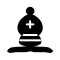
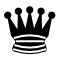
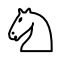
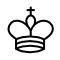
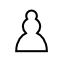
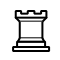
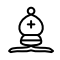
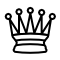
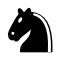
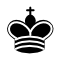

In [7]:
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000) 

In [8]:
#Create first agent

In [9]:
%%writefile main.py
from Chessnut import Game
import random

def chess_bot(obs):
    """
    Simple chess bot that prioritizes checkmates, then captures, queen promotions, then randomly moves.

    Args:
        obs: An object with a 'board' attribute representing the current board state as a FEN string.

    Returns:
        A string representing the chosen move in UCI notation (e.g., "e2e4")
    """
    # 0. Parse the current board state and generate legal moves using Chessnut library
    game = Game(obs.board)
    moves = list(game.get_moves())

    # 1. Check a subset of moves for checkmate
    for move in moves[:10]:
        g = Game(obs.board)
        g.apply_move(move)
        if g.status == Game.CHECKMATE:
            return move

    # 2. Check for captures
    for move in moves:
        if game.board.get_piece(Game.xy2i(move[2:4])) != ' ':
            return move
    # 3. Check for queen promotions
    for move in moves:
        if "q" in move.lower():
            return move

    # 4. Random move if no checkmates or captures
    return random.choice(moves)

Writing main.py


In [10]:
#Testing the agent

Agent exit status/reward/time left: 
	 DONE / 1 / 10
	 DONE / 0 / 10





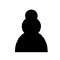
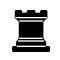
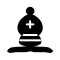
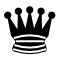
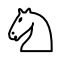
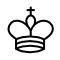
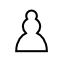
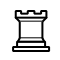
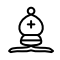
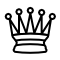
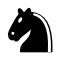
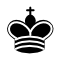

In [11]:
result = env.run(["main.py", "random"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=1000, height=1000) 

In [14]:
pip install python-chess


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148499 sha256=381412108d1244dad8e1d9198f49b883033e0ce9a697db928ace36d0ca56a528
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess
Note: you may need to restart the kernel to use updated packages.


In [17]:
%%writefile test.py
import chess
import random

def chess_bot(obs):
    """
    A simple chess bot that prioritizes checkmates, captures, queen promotions, then random moves.

    Args:
        obs: An object with a 'board' attribute representing the current board state as a FEN string.

    Returns:
        A string representing the chosen move in UCI notation (e.g., "e2e4").
    """
    # Parse the board state from FEN
    board = chess.Board(obs.board)

    # 1. Prioritize checkmate moves
    for move in board.legal_moves:
        board.push(move)
        if board.is_checkmate():
            board.pop()  # Undo move to maintain board state
            return move.uci()
        board.pop()

    # 2. Prioritize captures
    for move in board.legal_moves:
        if board.is_capture(move):
            return move.uci()

    # 3. Prioritize queen promotions
    for move in board.legal_moves:
        # Check if the move is a promotion to a queen
        if board.piece_at(move.from_square).piece_type == chess.PAWN and chess.square_rank(move.to_square) in (0, 7) and move.promotion == chess.QUEEN:
            return move.uci()

    # 4. Random fallback
    return random.choice(list(board.legal_moves)).uci()


Overwriting test.py


Agent exit status/reward/time left: 
	 DONE / 0 / 10
	 DONE / 1 / 10





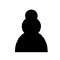
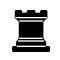
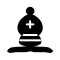
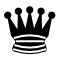
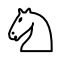
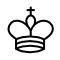
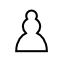
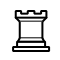
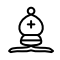
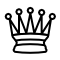
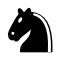
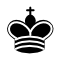

In [18]:
result = env.run(["test.py", "random"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=1000, height=1000) 